In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from random import randint
from tqdm import tqdm

import matplotlib.pyplot as plt

In [41]:
print(torch.backends.mps.is_available())
#device = torch.device("cpu")
device = torch.device("mps")

True


In [3]:
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset_train = FashionMNIST(root="../datasets/", train=True, download=True, transform=t)
dataset_test = FashionMNIST(root="../datasets/", train=False, download=True, transform=t)

In [4]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=10000, shuffle=False)

In [47]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [48]:
device = torch.device(device)
model = alexnet().to(device)

In [65]:
N_EPOCHS = 5

B_EPOCHS = int(60_000 / 32)

optim = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()
#loss_fn = nn.CrossEntropyLoss()
def acc_fn(pred, target):
  return (pred.argmax(dim=1)==target).sum()

In [ ]:
losses = []
accs = []

prog_bar = tqdm(range(N_EPOCHS))

for e in prog_bar:
    for i, (x, y) in enumerate(train_dataloader):
        optim.zero_grad()
        pred = model(x.to(device))

        loss = loss_fn(pred, y.to(device))
        losses.append(loss.item()/32)

        acc = acc_fn(pred.detach().cpu(), y.detach().cpu())
        accs.append(acc.item()/32)

        loss.backward()
        optim.step()
        if i % 150 == 0: 
            print(f"Epoch: {e} --- {i}/{B_EPOCHS} --- Loss: {loss.item()/32} --- Acc: {acc.item()/32}")

  0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch: 0 --- 0/1875 --- Loss: 0.007599061354994774 --- Acc: 0.875
Epoch: 0 --- 150/1875 --- Loss: 0.005976365879178047 --- Acc: 0.90625
Epoch: 0 --- 300/1875 --- Loss: 0.02035023272037506 --- Acc: 0.78125
Epoch: 0 --- 450/1875 --- Loss: 0.003871622495353222 --- Acc: 0.96875
Epoch: 0 --- 600/1875 --- Loss: 0.013894929550588131 --- Acc: 0.875
Epoch: 0 --- 750/1875 --- Loss: 0.007672848179936409 --- Acc: 0.875
Epoch: 0 --- 900/1875 --- Loss: 0.01035994105041027 --- Acc: 0.90625
Epoch: 0 --- 1050/1875 --- Loss: 0.003323981072753668 --- Acc: 0.96875
Epoch: 0 --- 1200/1875 --- Loss: 0.0038412148132920265 --- Acc: 0.9375
Epoch: 0 --- 1350/1875 --- Loss: 0.0066619208082556725 --- Acc: 0.875
Epoch: 0 --- 1500/1875 --- Loss: 0.0019996496848762035 --- Acc: 0.96875
Epoch: 0 --- 1650/1875 --- Loss: 0.005175736267119646 --- Acc: 0.9375
Epoch: 0 --- 1800/1875 --- Loss: 0.006365925073623657 --- Acc: 0.90625


 20%|██████▊                           | 1/5 [00:26<01:46, 26.55s/it]

Epoch: 1 --- 0/1875 --- Loss: 0.007127647288143635 --- Acc: 0.90625
Epoch: 1 --- 150/1875 --- Loss: 0.0036780997179448605 --- Acc: 1.0
Epoch: 1 --- 300/1875 --- Loss: 0.005550486966967583 --- Acc: 0.9375
Epoch: 1 --- 450/1875 --- Loss: 0.00908736977726221 --- Acc: 0.90625
Epoch: 1 --- 600/1875 --- Loss: 0.0014047094155102968 --- Acc: 1.0
Epoch: 1 --- 750/1875 --- Loss: 0.007888847962021828 --- Acc: 0.9375
Epoch: 1 --- 900/1875 --- Loss: 0.006937277503311634 --- Acc: 0.90625
Epoch: 1 --- 1050/1875 --- Loss: 0.005884057842195034 --- Acc: 0.875
Epoch: 1 --- 1200/1875 --- Loss: 0.012004050426185131 --- Acc: 0.90625
Epoch: 1 --- 1350/1875 --- Loss: 0.006490971893072128 --- Acc: 0.875
Epoch: 1 --- 1500/1875 --- Loss: 0.008171634748578072 --- Acc: 0.90625
Epoch: 1 --- 1650/1875 --- Loss: 0.0036201095208525658 --- Acc: 0.96875
Epoch: 1 --- 1800/1875 --- Loss: 0.012455828487873077 --- Acc: 0.875


 40%|█████████████▌                    | 2/5 [00:55<01:24, 28.12s/it]

Epoch: 2 --- 0/1875 --- Loss: 0.00490910978987813 --- Acc: 0.9375
Epoch: 2 --- 150/1875 --- Loss: 0.013345292769372463 --- Acc: 0.84375
Epoch: 2 --- 300/1875 --- Loss: 0.0028536710888147354 --- Acc: 0.96875
Epoch: 2 --- 450/1875 --- Loss: 0.006272486411035061 --- Acc: 0.90625
Epoch: 2 --- 600/1875 --- Loss: 0.005992564372718334 --- Acc: 0.90625
Epoch: 2 --- 750/1875 --- Loss: 0.005217758007347584 --- Acc: 0.9375
Epoch: 2 --- 900/1875 --- Loss: 0.010645868256688118 --- Acc: 0.875
Epoch: 2 --- 1050/1875 --- Loss: 0.0025278939865529537 --- Acc: 1.0
Epoch: 2 --- 1200/1875 --- Loss: 0.0034259844105690718 --- Acc: 0.96875
Epoch: 2 --- 1350/1875 --- Loss: 0.008354660123586655 --- Acc: 0.875
Epoch: 2 --- 1500/1875 --- Loss: 0.0071349721401929855 --- Acc: 0.90625
Epoch: 2 --- 1650/1875 --- Loss: 0.0029850671999156475 --- Acc: 0.96875
Epoch: 2 --- 1800/1875 --- Loss: 0.0020950136240571737 --- Acc: 0.96875


 60%|████████████████████▍             | 3/5 [01:25<00:57, 28.94s/it]

Epoch: 3 --- 0/1875 --- Loss: 0.006483664736151695 --- Acc: 0.90625
Epoch: 3 --- 150/1875 --- Loss: 0.01195040438324213 --- Acc: 0.875
Epoch: 3 --- 300/1875 --- Loss: 0.006488850340247154 --- Acc: 0.875
Epoch: 3 --- 450/1875 --- Loss: 0.008134160190820694 --- Acc: 0.90625
Epoch: 3 --- 600/1875 --- Loss: 0.008091106079518795 --- Acc: 0.9375
Epoch: 3 --- 750/1875 --- Loss: 0.004997453652322292 --- Acc: 0.9375


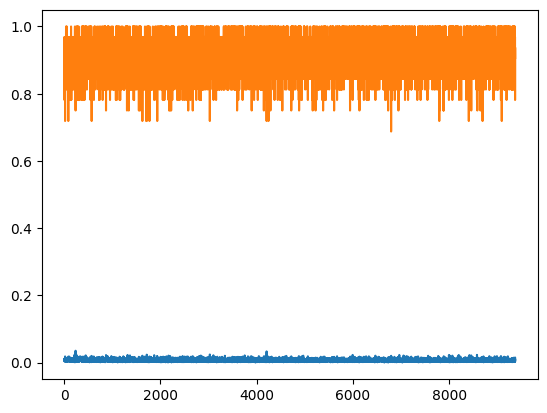

In [66]:
plt.plot(losses)
plt.plot(accs)

In [63]:
model.eval()
score = 0
for x, y in test_dataloader:
  score += acc_fn(model(x.to(device)).detach().cpu(), y)
print(score)

tensor(8976)
